## E-commerce website A/B testing


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, We will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.In the below cell lets find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "control" and landing_page == "new_page"').shape[0] + df.query('group == "treatment" and landing_page == "old_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.


In [8]:
df2 = df.query('group == "control" and landing_page == "old_page"').append(df.query('group == "treatment" and landing_page == "new_page"'))
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2['user_id'].value_counts()

773192    2
851104    1
644479    1
683486    1
738040    1
         ..
759865    1
877542    1
893884    1
856591    1
715931    1
Name: user_id, Length: 290584, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removeing **one** of the rows with a duplicate **user_id**.

In [13]:
df2.drop(1899, inplace = True)
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0



a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
p_population = df2['converted'].mean()
p_population

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2[df2['group'] == "control"]['converted'].mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2[df2['group'] == "treatment"]['converted'].mean()
p_treatment

0.11880806551510564

In [17]:
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [18]:
len(df2[df2['landing_page']=='new_page'])/df2.shape[0]

0.5000619442226688

e. Considering our results from a. through d. We Found That:

- > The users in the control group gets more conversions

<a id='ab_test'></a>
### Part II - A/B Test

The null and alternative hypotheses:

 
> **$H_0$**   :  **$p_{old}$** >= **$p_{new}$** <br>
> **$H_1$**   :  **$p_{old}$** < **$p_{new}$**

a. What is the **convert rate** for $p_{new}$ under the null? 

In [31]:
p_new = p_population
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [32]:
p_old = p_population
p_old

0.11959708724499628

c. What is $n_{new}$?

In [33]:
n_new =df2[df2['landing_page']=="new_page"]['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [34]:
n_old = df2[df2['landing_page']=="old_page"]['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [35]:
new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, 1-p_new])
p__new = new_page_converted.mean()
p__new

0.12023948799119125

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [36]:
old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = [p_old, 1-p_old])
p__old = old_page_converted.mean()
p__old

0.1181009678263144

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [37]:
p__new - p__old

0.0021385201648768393

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [38]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.

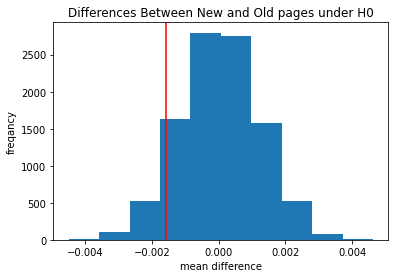

In [39]:
plt.hist(p_diffs)
plt.title("Differences Between New and Old pages under H0")
plt.xlabel('mean difference')
plt.ylabel('freqancy')
plt.axvline(obs_diff, color = "r");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [40]:
(p_diffs> obs_diff).mean()

0.9124

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [41]:
import statsmodels.api as sm

convert_old = df2.query('landing_page =="old_page" and converted == True')['user_id'].count()
convert_new = df2.query('landing_page =="new_page" and converted == True')['user_id'].count()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

In [45]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


- The P-value = 0.09 greater than the error rate which is 0.05, that suggests that we should fail to reject the null hypothesis. 

- they are agree with the findings in parts J and K.

<a id='regression'></a>
### Part III - A regression approach


- The Logistic Regression.

In [46]:
df2['ab_page'] = pd.get_dummies(df2['group'])[['treatment']]

In [47]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0


In [48]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])[['treatment']]
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,1


c. Using **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [49]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

In [50]:
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:               8.077e-06
Time:                        23:05:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

- the p_value associated with ab_page = 0.190
- the p-value differs from the another value in part two because of the null and alternative hypotheses in the logistic regression that are :
>  **$H_0$** : $p_{new}$ - $p_{old}$ = 0<br>
>  **$H_1$** : $p_{new}$ - $p_{old}$ $\neq$ 0 <br>
- this makes it a two sided t-test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- it's better to consider another variable 
- because the exponentiation of the correlation coefficient is very small to get consider in making a decision

In [51]:
countries_df = pd.read_csv('./countries.csv')
df_merged = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [52]:
### Create the necessary dummy variables
df_merged['intercept'] = 1 
df_merged[['CA', 'UK','US']] = pd.get_dummies(df_merged['country'])
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','CA','UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:               2.323e-05
Time:                        23:05:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [53]:
np.exp(results.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

> for every user recieves a new page the convertion rate is 0.985 times as likely,holding all other variables constant.
> for users in CA each one sees the new page increases the convertion rate 0.96 times.
> for users in UK each one sees the new page increases the convertion rate 1.009 times.

- These results suggest that the country where the user live affects the conversion rate.


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  


In [54]:
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [55]:
df_merged['ab_CA'] = df_merged['ab_page'] * df_merged['CA']
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']

In [57]:
### Fit Your Linear Model And Obtain the Results
# Fit your model, and summarize the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page','CA', 'UK', 'ab_CA','ab_UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:               3.482e-05
Time:                        23:30:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_CA         -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_UK          0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [58]:
np.exp(results.params)

intercept    0.137178
ab_page      0.979646
CA           0.982625
UK           0.994272
ab_CA        0.954198
ab_UK        1.031896
dtype: float64

<a id='conclusions'></a>
### Conclusions

> The p_value indicates that we fail to reject the null hypothesis as the p_value > 0.05, So also the country where the user live has no affect in using the new page.
> The company shouldn't move to the new page and stick to the old one.

